In [1]:
from PIL import Image
import os
import pathlib
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as sk_shuffle
from skimage.util import random_noise
from skimage import measure
import time
import os
from torch.utils import data
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from updated_data_dl import RetraceDataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from custom_unets import NestedUNet, U_Net, DeepNestedUNet
from sync_batchnorm import SynchronizedBatchNorm2d, DataParallelWithCallback, convert_model

import segmentation_models_pytorch as smp


import glob2
import pdb
import ipdb

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import torchvision.models as models
import torch.nn as nn

# rohan_unet = DeepNestedUNet(1,33)
rohan_unet = smp.FPN(encoder_name= "densenet121",
        encoder_depth= 5,
        encoder_weights= None,
        decoder_pyramid_channels= 256,
        decoder_segmentation_channels= 128,
        decoder_merge_policy= "add",
        decoder_dropout= 0.2,
        in_channels= 1,
        classes= 4,
        activation= None,
        upsampling= 4
    )


if torch.cuda.device_count() > 0:
      print("Let's use", torch.cuda.device_count(), "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      rohan_unet = nn.DataParallel(rohan_unet)
rohan_unet = rohan_unet.to(device)
rohan_unet = convert_model(rohan_unet)
rohan_unet.load_state_dict(torch.load('/home/rohan/prior_seg/models/viz_models/major_model3/gutta_model_epoch_25.0_f1_0.9444.pth'))


Let's use 2 GPUs!


<All keys matched successfully>

In [4]:
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# state_dict = torch.load('/home/rohan/prior_seg/models/prior_model1/1st_epoch_42.0000_f1_0.8835.pth',  map_location=device)
# for k, v in state_dict.items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# rohan_unet.load_state_dict(new_state_dict)
# unet_model = convert_model(unet_model)
# unet_model = unet_model.to(device)
rohan_unet = rohan_unet.to(device)
rohan_unet = rohan_unet.eval()

In [5]:
from torchsummary import summary
# summary(rohan_unet, input_size=(1,256,256))

In [6]:
root_dir = '/home/rohan/Datasets/prior_treatment_20200507/'
# syn_root_dir = '/home/rohan/Datasets/synthetic_prior_clean/train/'

# prior_data = RetraceDataLoader(root_dir, syn_root_dir, length = 100)
teeth_dataset = RetraceDataLoader(root_dir=root_dir,
                                  root_dir_synth=None, #syn_root_dir,
                                  image_size=(256,256),
                                  length = 'all',# pass 'all' for all
                                  transform=None)

Dataset length:  67766


In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = 1
shuffle_dataset = True
random_seed= 42
batch_size = 96

# Creating data indices for training and validation splits:
dataset_size = len(teeth_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

trainloader = torch.utils.data.DataLoader(
    teeth_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False,
    sampler=train_sampler,
    worker_init_fn=worker_init_fn,
    pin_memory = True,
    drop_last =True
)
valloader = torch.utils.data.DataLoader(
    teeth_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False,
    sampler=valid_sampler,
    worker_init_fn=worker_init_fn,
    pin_memory = True,
    drop_last =True
)
print ('Train size: ', len(trainloader))
print ('Validation size: ', len(valloader))

Train size:  0
Validation size:  705


In [8]:
import time
import copy
import pdb
import pandas as pd

dataloaders = {'train': trainloader,'val':valloader}
dataset_sizes = {'train':len(trainloader), 'val':len(valloader)}


SMOOTH = 1e-6

precision = smp.utils.metrics.Precision()
recall = smp.utils.metrics.Recall()

def dice_loss(input, target):
    smooth = SMOOTH
    
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

def dice_score(input, target):
    smooth = SMOOTH
#     print(input.shape)
#     ipdb.set_trace()
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

def dice_per_channel(inputs, target):
    
    dice_ch = 0.0
    dice_dict = {}
    for i in range(0, inputs.shape[1]):
        inp = inputs[:,i,:,:]
        inp = inp.contiguous()
        targs = target[:,i,:,:]
        targs = targs.contiguous()
        dice_chl = dice_score(inp,targs)
        dice_dict[i] = dice_chl.detach().cpu().numpy()
        dice_ch +=dice_chl
    
    return (dice_ch / (inputs.shape[1])), dice_dict

def metrics_per_channel(preds, bin_preds,target):
    
    dice_ch = 0.0
    dice_dict = {}
    pre_ch = 0.0
    pre_dict = {}
    rec_ch = 0.0
    rec_dict = {}
    
    for i in range(0, preds.shape[1]):
        inp = preds[:,i,:,:]
        inp = inp.contiguous()
        bin_inp = bin_preds[:,i,:,:]
        bin_inp = bin_inp.contiguous()
        targs = target[:,i,:,:]
        targs = targs.contiguous()
        
        dice_chl = dice_score(bin_inp,targs)
        dice_dict[i] = dice_chl.detach().cpu().numpy()
        dice_ch +=dice_chl
        
        pre_chl = precision(inp,targs)
        pre_dict[i] = pre_chl.detach().cpu().numpy()
        pre_ch +=pre_chl
        
        rec_chl = recall(inp,targs)
        rec_dict[i] = rec_chl.detach().cpu().numpy()
        rec_ch +=rec_chl
    
    dice_ch_avg = (dice_ch / (preds.shape[1]))
    pre_ch_avg = (pre_ch / (preds.shape[1]))
    rec_ch_avg = (rec_ch / (preds.shape[1]))
    
    return dice_ch_avg, dice_dict, pre_ch_avg, pre_dict, rec_ch_avg, rec_dict

def get_contours(masks):
    contours_dict = {}
    for i in range(masks.shape[0]):
        contours = measure.find_contours(masks[i].detach().cpu().numpy(), 0.5)
        contours_dict[i]=contours
    return contours_dict

def infer_model(model, output_df, ch_dice_df, ch_pre_df, ch_rec_df, num_epochs=15):
    start = time.time()
    out_dict={}
    
    running_f1=0.0
    running_pre = 0.0
    running_rec = 0.0
    
    running_f1_ch=0.0
    running_pre_ch = 0.0
    running_rec_ch = 0.0
    
    running_img_f1 = 0.0
    running_img_pre = 0.0
    running_img_rec = 0.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
#             ipdb.set_trace()
            for data in dataloaders[phase]:
#                 ipdb.set_trace()
                inputs = data['image'][:,:,:,:]
                labels = data['masks'][:,:,:,:]
                impaths = data['path']
#               labels = labels.unsqueeze(0)
#                 labels = labels.float()
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.type(torch.cuda.FloatTensor)
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs)
                    
                    bin_preds = preds.clone().detach()
                    bin_preds[bin_preds<=0.5]= 0.0
                    bin_preds[bin_preds>0.5]= 1.0
                    f1 = dice_score(bin_preds, labels)
                    pre = precision(preds, labels)
                    rec = recall(preds, labels)
                    f1_ch, ch_dice_dict, pre_ch, ch_pre_dict, rec_ch, ch_rec_dict = metrics_per_channel(preds, bin_preds, labels)
                    
                    ch_dice_df = ch_dice_df.append(ch_dice_dict, ignore_index=True)
                    ch_pre_df = ch_pre_df.append(ch_pre_dict, ignore_index=True)
                    ch_rec_df = ch_rec_df.append(ch_rec_dict, ignore_index=True)
                    
                    running_f1 += f1
                    running_f1_ch += f1_ch
                    running_pre += pre
                    running_pre_ch += pre_ch
                    running_rec += rec
                    running_rec_ch += rec_ch
                    
                    img_f1 = 0.0
                    img_pre = 0.0
                    img_rec = 0.0
                    for img, lbl, pred, bin_pred, im_path in zip(inputs, labels, preds, bin_preds, impaths):
                        out_dict = {}
                        
                        hard_dice = dice_score(bin_pred, lbl)
                        img_precision = precision(pred,lbl)
                        img_recall = recall(pred,lbl)
                        
                        img_f1 += hard_dice
                        img_pre += img_precision
                        img_rec += img_recall
                        
                        mask_contours = get_contours(lbl)
                        pred_contours = get_contours(pred)
                        out_dict['hard_dice'] = hard_dice.detach().cpu().numpy()
                        out_dict['input_image'] = img[0,:,:].detach().cpu().numpy()
                        out_dict['mask'] = mask_contours #np.argmax(np.flip(lbl.detach().cpu().numpy(),axis=0),axis=0)
                        out_dict['pred'] = pred_contours #np.argmax(np.flip(bin_pred.detach().cpu().numpy(),axis=0),axis=0)
                        out_dict['mask_classes'] = np.unique(np.argmax(np.flip(lbl.detach().cpu().numpy(),axis=0),axis=0))
                        out_dict['pred_classes'] = np.unique(np.argmax(np.flip(bin_pred.detach().cpu().numpy(),axis=0),axis=0))
                        out_dict['image_path'] = im_path
                        
#                         out_dict['act_image'] = act_img.numpy()
#                         out_dict['act_mask'] = act_mask.numpy()
#                         out_dict['act_tmask'] = act_tmask.numpy()
                        
                        output_df = output_df.append(out_dict, ignore_index=True)
                    batch_img_f1 = img_f1 / labels.shape[0]
                    running_img_f1 += batch_img_f1
                
                    batch_img_pre = img_pre / labels.shape[0]
                    running_img_pre += batch_img_pre
                    
                    batch_img_rec = img_rec / labels.shape[0]
                    running_img_rec += batch_img_rec
            
            torch.cuda.empty_cache()
#         ipdb.set_trace()
        epoch_f1 = running_f1 / dataset_sizes[phase]
        epoch_pre = running_pre / dataset_sizes[phase]
        epoch_rec = running_rec / dataset_sizes[phase]
        
        epoch_f1_ch = running_f1_ch / dataset_sizes[phase]
        epoch_pre_ch = running_pre_ch / dataset_sizes[phase]
        epoch_rec_ch = running_rec_ch / dataset_sizes[phase]
        
        epoch_img_f1 = running_img_f1 / dataset_sizes[phase]
        epoch_img_pre = running_img_pre / dataset_sizes[phase]
        epoch_img_rec = running_img_rec / dataset_sizes[phase]
        
        
        print('F1: {:.4f} '.format(epoch_f1))
        print('Precision: {:.4f} '.format(epoch_pre))
        print('Recall :{:.4f}'.format(epoch_rec))
        print('\n')
        print('F1 per channel: {:.4f} '.format(epoch_f1_ch))
        print('Precision per channel: {:.4f} '.format(epoch_pre_ch))
        print('Recall per channel: {:.4f} '.format(epoch_rec_ch))
        print('\n')
        print('F1 per Image: {:.4f} '.format(epoch_img_f1))
        print('Precision per Image: {:.4f} '.format(epoch_img_pre))
        print('Recall per Image: {:.4f} '.format(epoch_img_rec))
        print('\n')
        print('Epoch completed in {:.4f} seconds'.format(time.time()-start))
        torch.cuda.empty_cache()
        
    return model, output_df, ch_dice_df, ch_pre_df, ch_rec_df

In [9]:
import pandas as pd

output_df = pd.DataFrame(columns=['hard_dice','input_image', 'mask', 'pred', 'mask_classes', 'pred_classes', 'image_path'])
ch_dice_df = pd.DataFrame()
ch_pre_df = pd.DataFrame()
ch_rec_df = pd.DataFrame()
model_out, output_df, ch_dice_df, ch_pre_df, ch_rec_df = infer_model(rohan_unet, output_df, ch_dice_df, ch_pre_df, ch_rec_df, num_epochs=1)

Epoch 0/0
----------
F1: 0.9535 
Precision: 0.9568 
Recall :0.9502


F1 per channel: 0.9307 
Precision per channel: 0.9361 
Recall per channel: 0.9258 


F1 per Image: 0.9090 
Precision per Image: 0.9374 
Recall per Image: 0.9252 


Epoch completed in 1460.9035 seconds


<h4>###########</h4>
<h4>Crown+Gutta+Filling Expt (No Inlay/Onlay) Metrics</h4>
<p>Epoch 0/0
<br>----------
<br>F1: 0.9243 
<br>Precision: 0.9332 
<br>Recall :0.9159
<br>

<br>F1 per channel: 0.9047 
<br>Precision per channel: 0.9101 
<br>Recall per channel: 0.9014 
<br>

<br>F1 per Image: 0.8812 
<br>Precision per Image: 0.9197 
<br>Recall per Image: 0.8947

In [10]:
mean_ch_dice = ch_dice_df.mean(axis=0)
mean_ch_pre = ch_pre_df.mean(axis=0)
mean_ch_rec = ch_rec_df.mean(axis=0)


In [11]:
sorted_df = output_df.sort_values('hard_dice', ignore_index = True)

In [20]:
# sorted_df.to_pickle('/home/rohan/prior_seg/output_sortedDF_final.pkl')

In [12]:
sorted_df.head()

,hard_dice,input_image,mask,pred,mask_classes,pred_classes,image_path
0,5.1991265e-11,"[[0.05882353, 0.2, 0.11764706, 0.14901961, 0.1...","{0: [], 1: [[[190.5 122. ], [190.5 121. ], [19...","{0: [], 1: [], 2: [[[182.04846979 227. ...","[0, 2]","[0, 1]",/home/rohan/Datasets/prior_treatment_20200507/...
1,7.3768075e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: [], 1: [[[132.5 0. ], [132. 0.5], [13...","{0: [], 1: [], 2: [], 3: []}","[0, 2]",[0],/home/rohan/Datasets/prior_treatment_20200507/...
2,7.506944e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: [], 1: [[[168.5 71. ], [168.5 70. ], [16...","{0: [], 1: [], 2: [[[185.00823555 109. ...","[0, 1, 2]","[0, 1]",/home/rohan/Datasets/prior_treatment_20200507/...
3,8.0925794e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: [], 1: [[[213.5 255. ], [214. 254.5], [21...","{0: [], 1: [], 2: [], 3: []}","[0, 2]",[0],/home/rohan/Datasets/prior_treatment_20200507/...
4,9.616309e-11,"[[0.8392157, 0.7137255, 0.7137255, 0.7529412, ...","{0: [], 1: [[[255. 109.5], [254.5 109. ], [25...","{0: [], 1: [], 2: [], 3: []}","[0, 2]",[0],/home/rohan/Datasets/prior_treatment_20200507/...


In [13]:
class_df = sorted_df[['mask_classes','pred_classes']]

In [14]:
mask_class_vec = np.zeros((4))
pred_class_vec = np.zeros((4))

majority_dict = {'crown':1, 'bridge':1, 'temporary-filling':2, 'filling-composite':2, 'filling-glass':2, 'filling-metal':2 , 'onlay-composite':2,
               'onlay-metal':2, 'onlay-ceramic':2, 'inlay-ceramic':2, 'inlay-composite':2, 'inlay-metal':2, 'gutta-percha':3 } 

reverse_majority_dict = {1:'crown', 2:'restorative', 3 : 'gutta-percha'}

majority_cdict = {'restorative': '#ff3c45', 'crown':'#CDFF00', 'gutta-percha':'#00FFA6' }


for ele in class_df.mask_classes:
    for x in ele:
        mask_class_vec[x] +=1

for ele in class_df.pred_classes:
    for x in ele:
        pred_class_vec[x] +=1

In [15]:
# fig, ax = plt.subplots(figsize=(60,20))
x = np.arange(1,len(mask_class_vec))
# y= np.arange(0,3000,100)
# width = 0.35


# rect1 = ax.bar(x - width/2, mask_class_vec[1:], width, label = 'Ground Truth')
# rect2 = ax.bar(x + width/2, pred_class_vec[1:], width, label = 'Predictions')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('')
# ax.set_title('')
# ax.set_xticks(x)
# ax.set_yticks(y)
# ax.set_xticklabels(x)
# ax.legend( fontsize=20)


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(list(reverse_majority_dict.values())[rects.index(rect)]),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, random.choice(range(5,75, 10))),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=20
#                    )


# autolabel(rect1)
# autolabel(rect2)

# fig.tight_layout()

# plt.show()

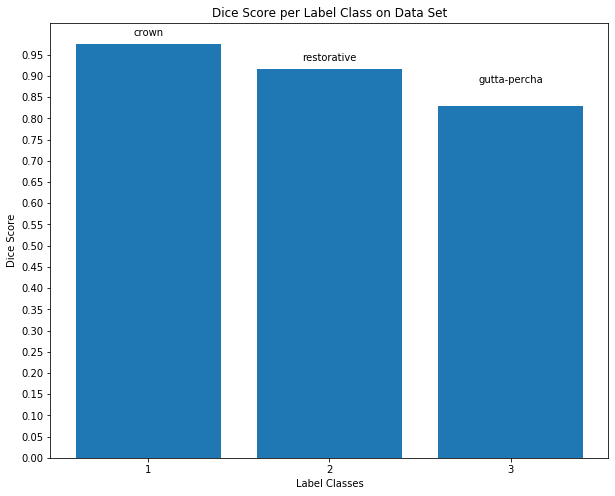

In [32]:
f, ax = plt.subplots(figsize = (10,8))
ax.set_xticklabels(x)
ax.set_xticks(x)
y = np.arange(0,1,0.05)
ax.set_yticks(y)
rect3 = ax.bar(range(1,len(mean_ch_dice)), mean_ch_dice[1:])
ax.set_xlabel('Label Classes')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Score per Label Class on Data Set')
# key_list = ['background']
# key_list.extend(list(prior_dict.keys()))

def autolabel1(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(list(reverse_majority_dict.values())[rects.index(rect)]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, random.choice(range(1,25, 5))),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   )

autolabel1(rect3)

In [ ]:
# f, ax = plt.subplots(figsize = (25,10))
# ax.set_xticklabels(x)
# ax.set_xticks(x)
# ax.set_yticks(y)
# rect3 = ax.bar(range(1,len(mean_ch_pre)), mean_ch_dice[1:])
# ax.set_xlabel('Label Classes')
# ax.set_ylabel('Precision')
# ax.set_title('Precision per Label Class on Test Set')
# # key_list = ['background']
# # key_list.extend(list(prior_dict.keys()))

# def autolabel1(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(list(reverse_majority_dict.values())[rects.index(rect)]),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, random.choice(range(1,25, 5))),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom'
#                    )

# # autolabel1(rect3)

In [ ]:
# f, ax = plt.subplots(figsize = (25,10))
# ax.set_xticklabels(x)
# ax.set_xticks(x)
# ax.set_yticks(y)
# rect3 = ax.bar(range(1,len(mean_ch_rec)), mean_ch_dice[1:])
# ax.set_xlabel('Label Classes')
# ax.set_ylabel('Recall')
# ax.set_title('Recall per Label Class on Test Set')
# # key_list = ['background']
# # key_list.extend(list(prior_dict.keys()))

# def autolabel1(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(list(reverse_majority_dict.values())[rects.index(rect)]),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, random.choice(range(1,25, 5))),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom'
#                    )

# # autolabel1(rect3)

In [33]:
# new_df = pd.DataFrame(columns = sorted_df.columns)

# for i in range(len(sorted_df)):
#     if len(sorted_df['mask'][i].keys())>1:
#         new_df = new_df.append({'hard_dice':sorted_df.hard_dice[i], 'input_image':sorted_df.input_image[i], 'mask':sorted_df['mask'][i], 'pred':sorted_df.pred[i]}, ignore_index=True)

# new_df.head()

In [34]:
low_100 = sorted_df[:50]
top_100 = sorted_df[-50:]
conditional_top100 = sorted_df[sorted_df.hard_dice<1.0][-50:]
conditional_low100 = sorted_df[sorted_df.hard_dice>0.2][:50]
conditional_low_dice = sorted_df[sorted_df.hard_dice<0.3]

In [35]:
prior_dict = {'crown':1, 'bridge':2,
               'gutta-percha':3, 'pin':4, 'post':5, 'buildup':6, 'calculus':7, 'sealer':8,
               'cement':9, 'bracket':10, 'retainer':11, 'instrument':12, 'implant':13, 'screw':14,
               'veneer':15, 'silver-point':16, 'space-maintainer':17, 'core':18, 'base':19,
               'temporary-filling':20, 'medicament':21, 'framework':22, 'liner':23, 'onlay-composite':24,
               'onlay-metal':25, 'onlay-ceramic':26, 'inlay-ceramic':27, 'inlay-composite':28, 'inlay-metal':29,
               'filling-composite':30, 'filling-glass':31, 'filling-metal':32}

reverse_prior_dict = {v: k for k, v in prior_dict.items()}


colors_dict ={

  '1':'#ff7b00','2':'#0073ff','3':'#ffce00','4':'#00efff',

  '5':'#0800ff','6':'#ffa600','7':'#8cff00','8':'#fff700',

  '9':'#5a00ff','10':'#004aff','11':'#ff8800','12':'#ff00e6',

  '13':'#63ff00','14':'#ad00ff','15':'#00ffbd','16':'#ff0000',

  '17':'#00c5ff','18':'#10ff00','19':'#d600ff','20':'#00ff94',

  '21':'#8400ff','22':'#0088ff','23':'#3aff00','24':'#ff2900',

  '25':'#deff00','26':'#3100ff','27':'#ffaa00','28':'#00ff19',

  '29':'#00ffe6','30':'#0021ff','31':'#b5ff00','32':'#ff5200',

  'a':'#ff7b88','b':'#007388','c':'#ffce88','d':'#00ef88',

  'e':'#080088','f':'#ffa688','g':'#8cff88','h':'#fff788',

  'i':'#5a0088','j':'#004a88','k':'#ff8888','l':'#ff00e6',

  'm':'#63ff88','n':'#ad0088','o':'#00ffbd','p':'#ff0088',

  'q':'#00c588','r':'#10ff88','s':'#d60088','t':'#00ff94',

  'conecut':'#00fbff',

  'caries':'#ff0000',

  'caries2':'#800080',
  'caries3':'#800080',  

'crown':'#CDFF00',
'bridge':'#9EFF00',
'gutta-percha':'#00FFA6',
'pin':'#00FFD8',
'post':'#00E0FF',
'buildup':'#00A2FF',
'calculus':'#0042FF',
'sealer':'#8000FF',
'cement':'#00ff44',
'bracket':'#84ff00',
'retainer':'#ffcc00',
'instrument':'#458cff',
'implant':'#c145ff',
'screw':'#ec45ff',
'veneer':'#ff45f3',
'silver-point':'#ff45d1',
'space-maintainer':'#ff45ae',
'core':'#ff4589',
'base':'#ff4548',
'temporary-filling':'#ff6145',
'medicament':'#ff7a45',
'framework':'#ff9c45',
'liner':'#e3ff45',
'onlay-composite':'#fff045',
'onlay-metal':'#fff045',
'onlay-ceramic': '#fff045',
'inlay-ceramic':'#ffbe45',
'inlay-composite':'#ffbe45',
'inlay-metal':'#ffbe45',
'filling-composite':'#FF00E8',
'filling-glass':'#FF00E8',
'filling-metal':'#FF00E8'    
}

majority_dict = {'crown':1, 'bridge':1, 'temporary-filling':2, 'filling-composite':2, 'filling-glass':2, 'filling-metal':2 , 'onlay-composite':2,
               'onlay-metal':2, 'onlay-ceramic':2, 'inlay-ceramic':2, 'inlay-composite':2, 'inlay-metal':2, 'gutta-percha':3 } 

reverse_majority_dict = {1:'crown', 2:'restorative', 3 : 'gutta-percha'}

majority_cdict = {'restorative': '#ff3c45', 'crown':'#CDFF00', 'gutta-percha':'#00FFA6' }


In [ ]:
# plt.yticks(np.arange(0, 70000, 1000))
# ax = sorted_df.hard_dice.hist(figsize = (15,15))
# plt.xlabel('Dice Score', fontsize=16)
# plt.ylabel('No. of Images', fontsize=16)
# plt.suptitle('Data Set Dice Score Histogram',y=0.9, fontsize=16)

In [48]:
# preds_numpy = preds.detach().numpy()
def plotter(input_img, gt_mask, pred, f1, idx, title):
    f, ax = plt.subplots(1 , 3, figsize=(25,25))
    ax[0].imshow(input_img, cmap='gray')
    
    ax[1].imshow(input_img, cmap='gray')
    for k, cnts in gt_mask.items():
        if len(cnts)>0:
            for cnt in cnts:
#                 ipdb.set_trace()
                ax[1].plot(cnt[:, 1], cnt[:, 0],linewidth=2,color=colors_dict[reverse_prior_dict[k]], label = reverse_prior_dict[k])
    
    ax[2].imshow(input_img, cmap='gray')
    for k, cnts in pred.items():
        if len(cnts)>0:
            for cnt in cnts:
                ax[2].plot(cnt[:, 1], cnt[:, 0],linewidth=2,color=majority_cdict[reverse_majority_dict[k]],linestyle='dotted', label = reverse_majority_dict[k])
    
    ax[0].set_xlabel('Input Image',fontsize=16)
    ax[1].set_xlabel('Ground Truth Mask',fontsize=16)
    ax[2].set_xlabel('Prediction Image'.format(f1),fontsize=16)
    ax[2].set_title('Dice = {:.4f}'.format(f1),fontsize=16)
    f.tight_layout()
    plt.figlegend()
    if idx == 0:
        f.suptitle(title, fontsize=16)
        
    plt.show()

def get_plot_contours(masks):
    contours_dict = {}
    for i in range(masks.shape[0]):
        contours = measure.find_contours(masks[i], 0.5)
        contours_dict[i]=contours
    return contours_dict
    
def plot_df(df, title):
    

    for i in range(len(df)):
        input_img = df.input_image[df.index[i]]
#         gt_mask = df['mask'][df.index[i]]
        pred = df.pred[df.index[i]]
        f1 = df.hard_dice[df.index[i]]
        masks_dir = df.image_path[df.index[i]][:-7].replace('images', 'masks')
        label_path = glob2.glob(masks_dir + '/*.jpg')
#         lb_names = [m.split('/')[-1].split('.')[0] for m in label_path]
#         print(lb_names)
        masks = np.zeros(shape=[33,input_img.shape[0],input_img.shape[1]])
        for m in label_path:
            label_name = m.split('/')[-1].split('.')[0]
            if label_name in list(prior_dict.keys()):
                mask = cv2.imread(m,0)
                mask = cv2.resize(mask, (input_img.shape[1],input_img.shape[0]),
                                        interpolation = cv2.INTER_NEAREST)
                mask[mask>=0.5]=1
                mask[mask<0.5]=0
                masks[prior_dict[label_name],:,:]+=mask
                
        gt_mask = get_plot_contours(masks)
#         ipdb.set_trace()
        print('Image Number : {}'.format(i+1))
        print(df.image_path[df.index[i]])
        plotter(input_img, gt_mask, pred, f1, i, title)
    
#     f.tight_layout()
#     f.suptitle(title,y=1.001, fontsize=16)
#     plt.figlegend()
    
    
    
    

# plot_df(low_100, 'Images with low hard dice value')

In [42]:
# plot_df(top_100, 'Images with high hard dice value')

In [41]:
# plot_df(conditional_top100, 'Images with high hard dice value')

In [40]:
# plot_df(conditional_low100, 'Images with low hard dice value')

In [52]:
# plot_df(conditional_low_dice[-100:], 'Images with low hard dice value')

In [53]:
conditional_low_dice.head()

,hard_dice,input_image,mask,pred,mask_classes,pred_classes,image_path
0,5.1991265e-11,"[[0.05882353, 0.2, 0.11764706, 0.14901961, 0.1...","{0: [], 1: [[[190.5 122. ], [190.5 121. ], [19...","{0: [], 1: [], 2: [[[182.04846979 227. ...","[0, 2]","[0, 1]",/home/rohan/Datasets/prior_treatment_20200507/...
1,7.3768075e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: [], 1: [[[132.5 0. ], [132. 0.5], [13...","{0: [], 1: [], 2: [], 3: []}","[0, 2]",[0],/home/rohan/Datasets/prior_treatment_20200507/...
2,7.506944e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: [], 1: [[[168.5 71. ], [168.5 70. ], [16...","{0: [], 1: [], 2: [[[185.00823555 109. ...","[0, 1, 2]","[0, 1]",/home/rohan/Datasets/prior_treatment_20200507/...
3,8.0925794e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: [], 1: [[[213.5 255. ], [214. 254.5], [21...","{0: [], 1: [], 2: [], 3: []}","[0, 2]",[0],/home/rohan/Datasets/prior_treatment_20200507/...
4,9.616309e-11,"[[0.8392157, 0.7137255, 0.7137255, 0.7529412, ...","{0: [], 1: [[[255. 109.5], [254.5 109. ], [25...","{0: [], 1: [], 2: [], 3: []}","[0, 2]",[0],/home/rohan/Datasets/prior_treatment_20200507/...


In [62]:
low_dice_image_paths = pd.DataFrame(columns=['image_paths', 'ids']) #

In [75]:
type(conditional_low_dice.image_path[1])

str

In [92]:
low_dice_image_paths = pd.DataFrame(columns=['image_paths', 'ids']) #
for i in range(len(conditional_low_dice)):
    df_dict = {}
    ele = conditional_low_dice.image_path[i]
#     ipdb.set_trace()
    df_dict['image_paths'] = ele
    df_dict['ids'] = ele.split('/')[-2].split('_')[0]
    low_dice_image_paths = low_dice_image_paths.append(df_dict, ignore_index=True)
#     low_dice_ids.append(pth.split('/')[-2].split('_')[0])

In [102]:
low_dice_image_paths.image_paths[2500]

'/home/rohan/Datasets/prior_treatment_20200507/images/1.190926791160849.9593.42876.876.81.376826738.4.721377348812.7/1.190926791160849.9590.438116.52.81.3768260.406.7213715.704765_Anterior2MaxillaL/im.jpg'

In [103]:
low_dice_image_paths.ids[2500]

'1.190926791160849.9590.438116.52.81.3768260.406.7213715.704765'

In [105]:
id_df = low_dice_image_paths.ids

In [108]:
id_df.to_csv('/home/rohan/mislabelled_prior_ids.csv', index=False)

In [111]:
id_df[2500]

'1.190926791160849.9590.438116.52.81.3768260.406.7213715.704765'